In [1]:
import maboss
import os
import matplotlib.pyplot as plt
from tools import change_inputs, to_istates

In [2]:
path = "../config/differentiation/boolean_network/"

In [3]:
bnd_file = os.path.join(path,"tcell_corral.bnd")
cfg_file = os.path.join(path,"tcell_corral.cfg")

tcell_sim = maboss.load(bnd_file, cfg_file)

# Wild type Tcell
This is a simulation where all the nodes are 0. The starting point of the PysiBoSS simulation.

We choose to include all the nodes in the results as they will be used as a starting point of a following simulation. 


In [4]:
sim = tcell_sim.copy()
sim.network.set_output(sim.network.keys())
sim.update_parameters(sample_count=1000,max_time=100, time_tick=0.5)
maboss.set_nodes_istate(sim, sim.network.keys(), [1, 0])

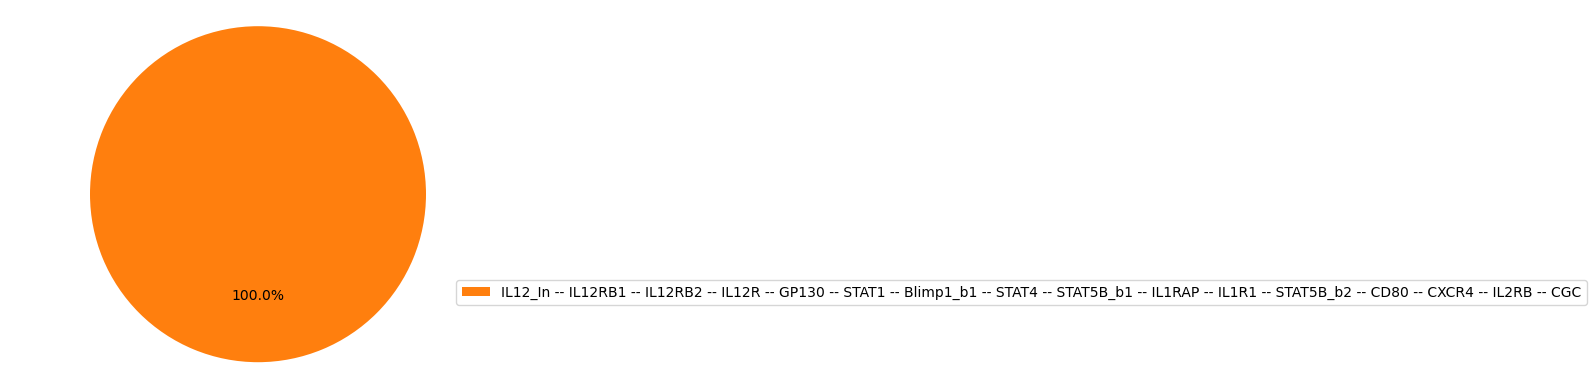

In [5]:
model = sim.run()
model.plot_piechart()

The result of the previous simulation shows that none of the phenotype nodes (Treg, Th17, Th1) are active, and that the cells are in a fixed point corresponding to the naive state. 


Now we will simulate the effect of the dendritic cells binding and deliver their signal to the naive T cell.

In [6]:
dc_signal = {node:1 for node in ["IL1_In", "MHCII_b1", "MHCII_b2", "IL12_In", "IL6_In", "CD4", "CD80", "IL23_In", "PIP2"]}

In [7]:
output_maboss = ["Treg", "Th17", "Th1"]

In [8]:
nodes = list(sim.network.keys())

Now we assign the previous final state as the initial state for a new simulation and on top of that we are going to activate the input nodes that the dendritic cells will activate in the PhysiBoSS simulation.

In [9]:
new_istates = change_inputs(nodes, to_istates(model.get_states_probtraj(), nodes), dc_signal)

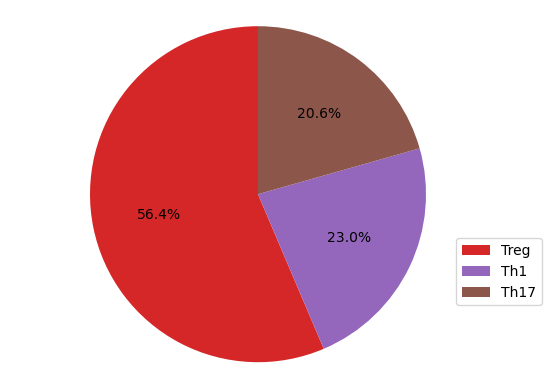

In [10]:
sim_next = sim.copy()
sim_next.network.set_output(output_maboss)
sim_next.update_parameters(sample_count=1000,max_time=100, time_tick=0.5)
sim_next.network.set_istate(nodes, new_istates)


model_activated = sim_next.run()
model_activated.plot_piechart()

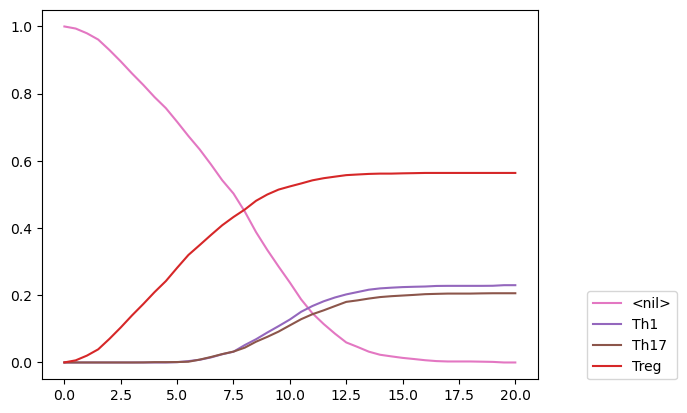

In [11]:
model_activated.plot_trajectory(until=20)

The input delivered by the dendritic cells, will allow the differentiation of the naive tcell into Treg, Th17 and Th1

# Analysis of the Mutants

## Single mutants

Now we are going to test a series of mutations in the model. To perform this kind of analysis, we are not going to test the mutations on the wild type state, but on the stable state prior to contact with the dendritic cells. Moreover, we are going to test the input delivered by the dendritic cells to those mutations results that did not trigger any differentiation. The objective of this analysis is to search for undifferentiated stable state of the network that are more vulnerable or more resistant to the dendritic cell contact.

In [12]:
def compute_input_on_mutations(model, res_mutations, nodes, inputs):
    new_results = {}
    for mutation_target in res_mutations:
        mutation_result = res_mutations[mutation_target]
        new_istates = change_inputs(nodes, to_istates(mutation_result.get_states_probtraj(), nodes), inputs)
        s_model = model.copy()
        s_model.network.set_istate(nodes, new_istates)
        if isinstance(mutation_target[0], str):
            s_model.mutate(*mutation_target)
        else:
            for mutant in mutation_target:
                s_model.mutate(*mutant)
        new_results.update({mutation_target: s_model.run()})
    return new_results
        

In [13]:
sim_test_single_mut = sim.copy()

In [14]:
nodes_test = ['PI3K_b1', 'PI3K_b2', 'IL6_Aut', 'IL12R', 'IL6R', 'STAT1', 'Tbet', 'AP1', 'NFAT1', 'NFKB', 'Blimp1_b1', 'Blimp1_b2', 'RUNX1_b1', 'RUNX1_b2', 'STAT4', 'RUNX3', 'EOMES', 'IFNg', 'IL12RB1', 'IL12RB2', 'IL1RAP', 'IL1R1', 'IL1R', 'IL23R', 'STAT3', 'cMAF', 'IL21', 'RORGt', 'IRF4', 'AHR', 'NFAT2A_b1', 'NFAT2A_b2', 'STAT5B_b1', 'STAT5B_b2', 'SMAD2', 'RORA', 'STAT5A_b1', 'STAT5A_b2', 'IL17A', 'IL17F', 'LCK', 'TCR_b1', 'TCR_b2', 'CD28', 'ZAP70', 'LAT', 'VAV', 'RAS', 'SOS', 'PLCG', 'RAC', 'FOXP3', 'PTEN', 'PIP3', 'IP3', 'DAG', 'PKCO', 'ITK_b1', 'ERK1_2', 'cFOS', 'cJUN', 'MEKK1', 'TRAF6', 'TAK1', 'IKK', 'Myd88', 'IRAK1_4', 'NFAT2', 'NFAT4', 'IL2RA', 'IL2RB', 'CGC', 'IL2', 'IL2R_b1', 'IL2R_b2', 'SATB1', 'TGFBR', 'GP130', 'MINA', 'FOXP3_2', 'TGFB_In', 'CXCR4', 'ITK_b2']

In [15]:
res_single = maboss.pipelines.simulate_single_mutants(sim_test_single_mut, nodes_test)

In the following cell, we filter the results because we want to test the input delivered by the mDCs on an undifferentiated population of T0.

In [16]:
filtered_res = maboss.pipelines.filter_sensitivity(res_single, node="Treg", maximum=0.0)
filtered_res = maboss.pipelines.filter_sensitivity(filtered_res, node="Th1", maximum=0.0)
filtered_res = maboss.pipelines.filter_sensitivity(filtered_res, node="Th17", maximum=0.0)

In [17]:
stable_state = sim.copy()
nodes = list(stable_state.network.keys())
stable_state.network.set_output(output_maboss)

In [18]:
updated_mutations = compute_input_on_mutations(stable_state, filtered_res, nodes, dc_signal)

In [19]:
filtered_mutations_Treg = maboss.pipelines.filter_sensitivity(updated_mutations, node="Treg", minimum=0.8)

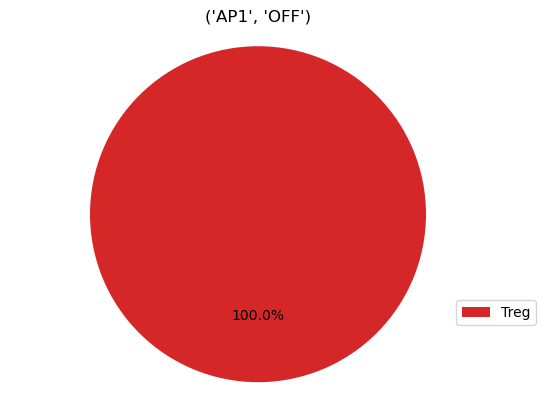

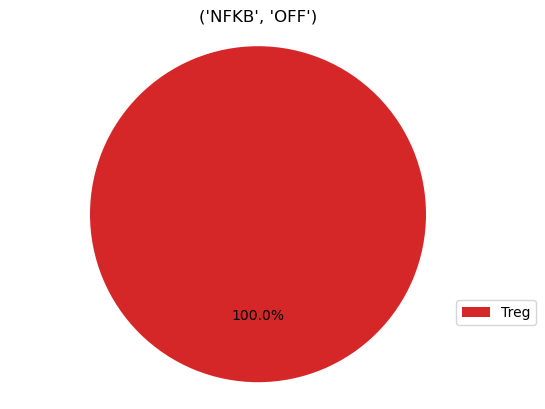

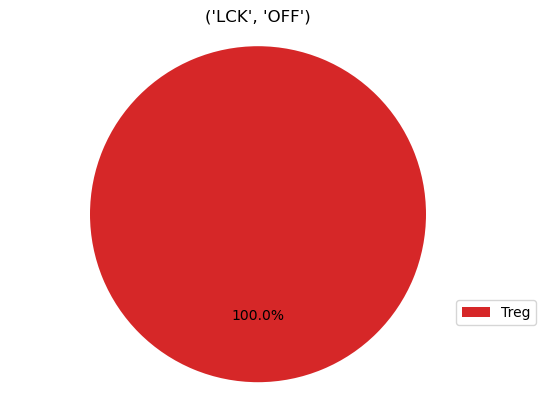

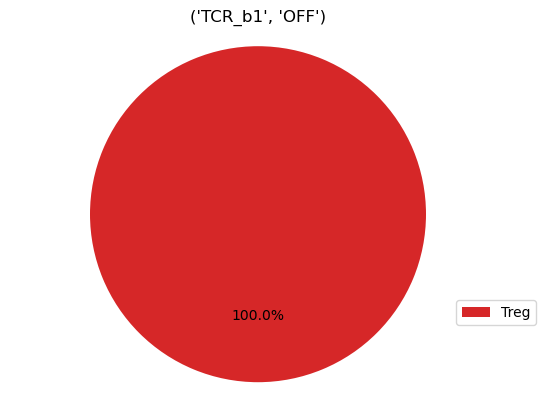

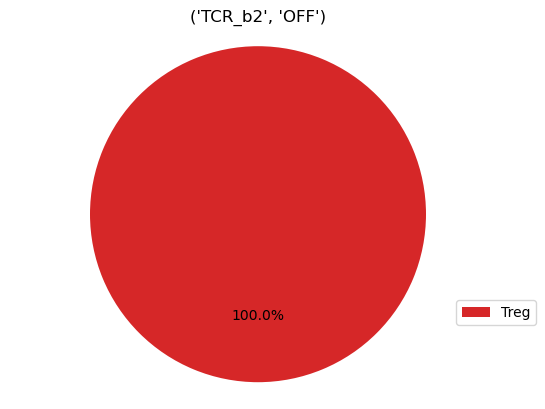

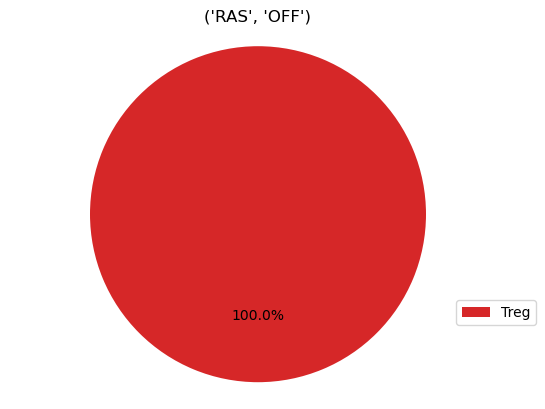

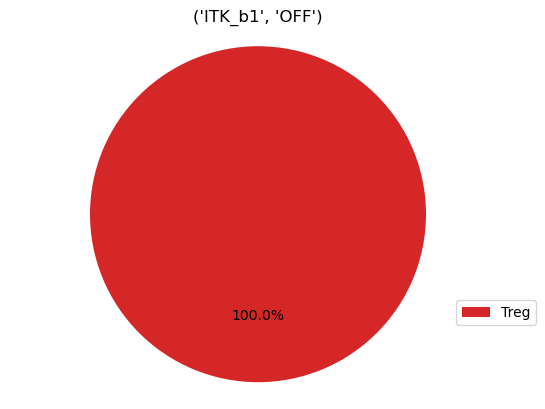

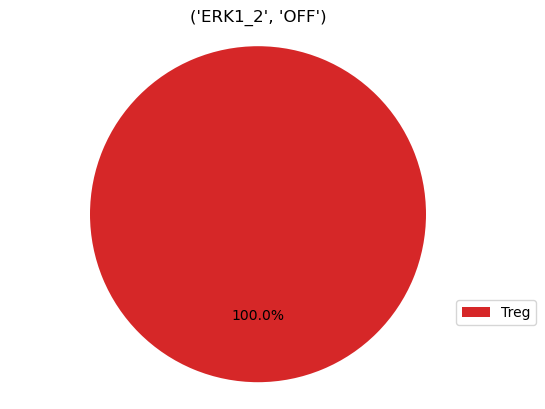

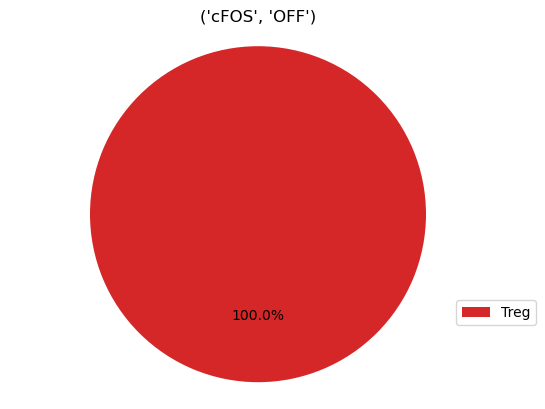

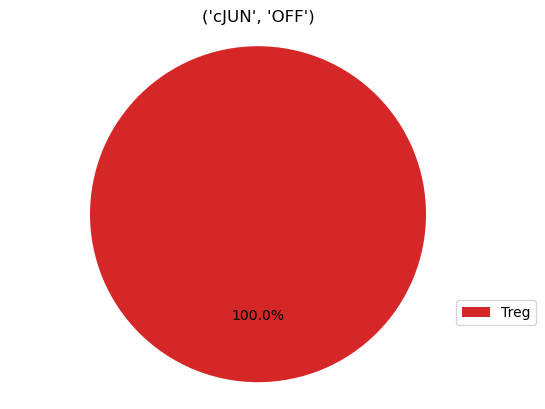

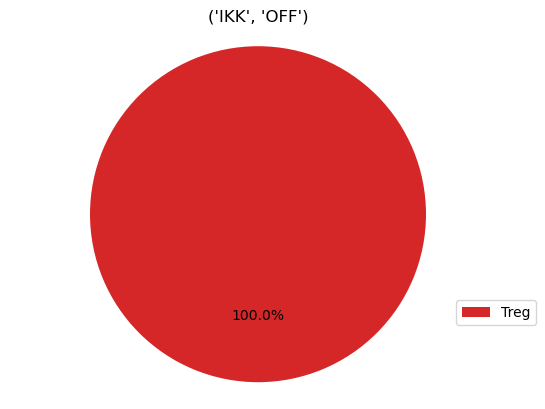

In [20]:
for mutant, res in filtered_mutations_Treg.items():
    res.plot_piechart()
    plt.title(mutant)

In [21]:
filtered_mutations_Th1 = maboss.pipelines.filter_sensitivity(updated_mutations, node="Th1", minimum=0.5)

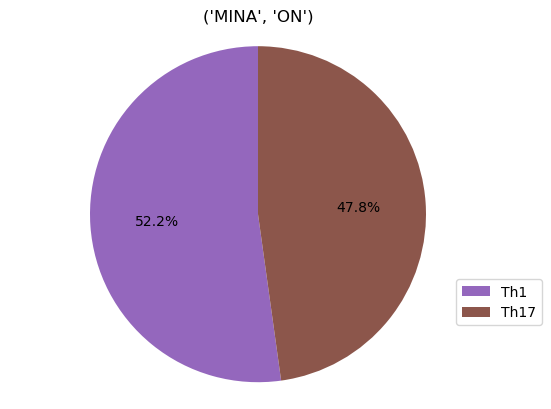

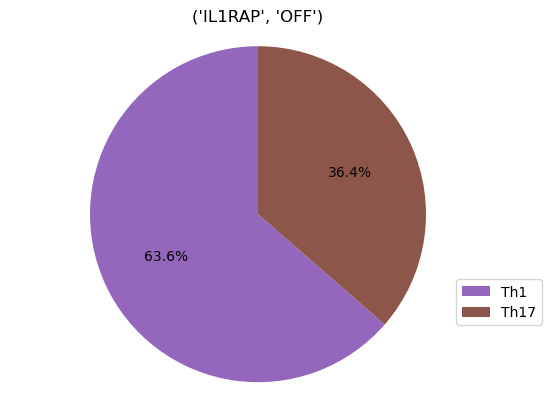

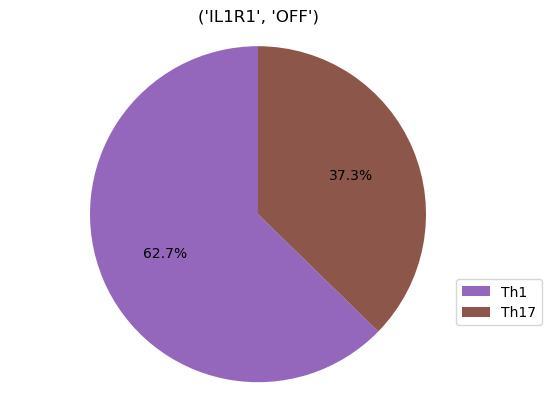

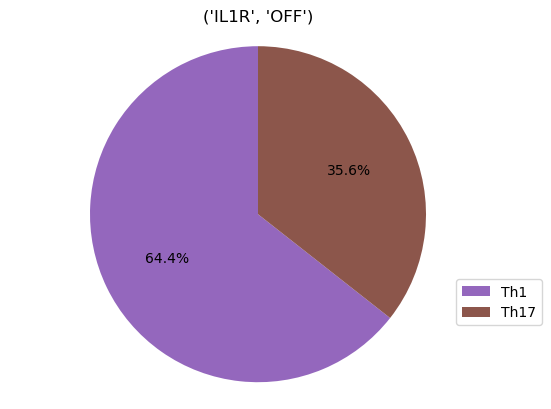

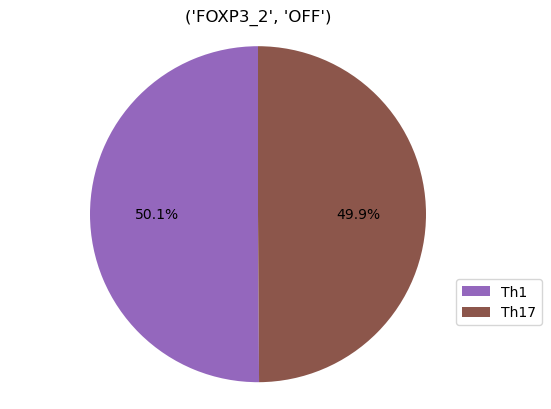

In [22]:
for mutant, res in filtered_mutations_Th1.items():
    res.plot_piechart()
    plt.title(mutant)


In [23]:
filtered_mutations_Th17 = maboss.pipelines.filter_sensitivity(updated_mutations, node="Th17", minimum=0.4)

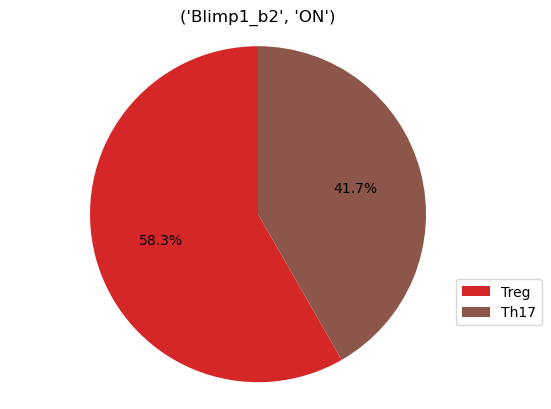

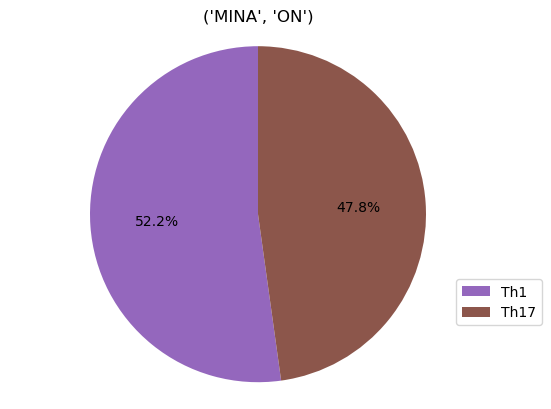

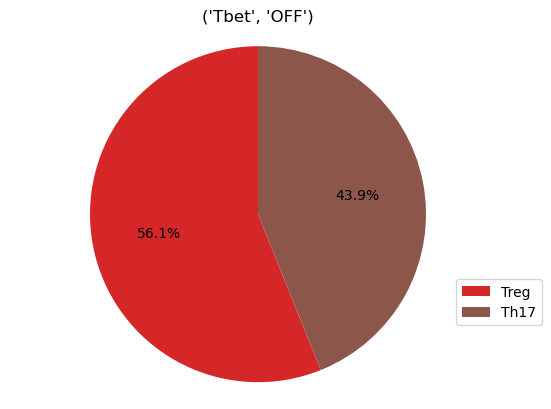

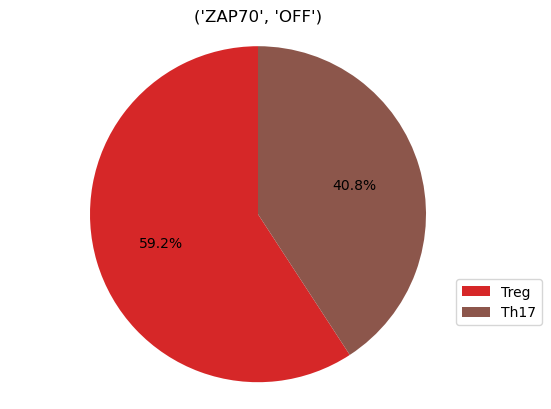

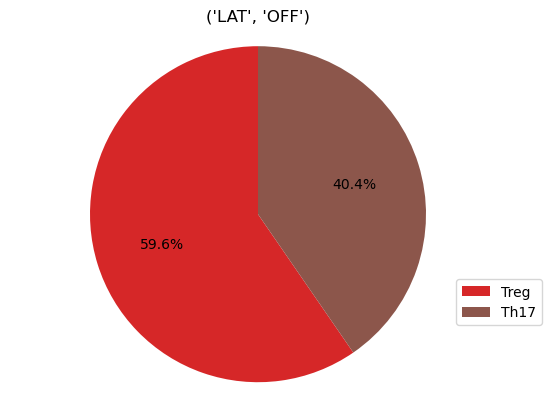

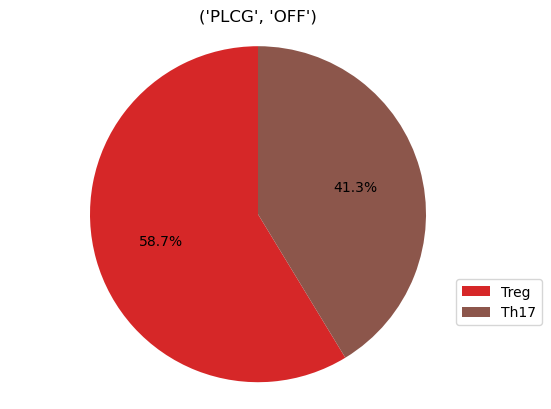

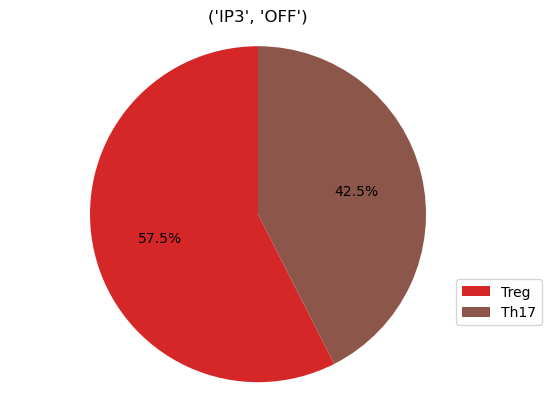

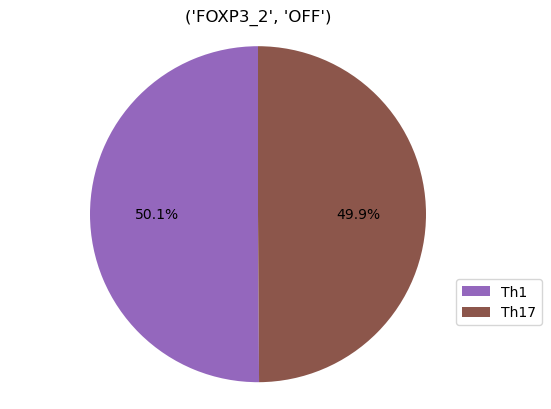

In [24]:
for mutant, res in filtered_mutations_Th17.items():
    res.plot_piechart()
    plt.title(mutant)

As we can observe, several single mutations resulted in a drastic change of the original model behavior. 

## Parameters

Now that we saw that playing with mutations, we can modify the distribution of phenotypes, let's do something more : play with activation/inactivation parameters. 
Let's choose two mutants that showed some effect : NFkB--, and FOXP3_2--


### NFkB

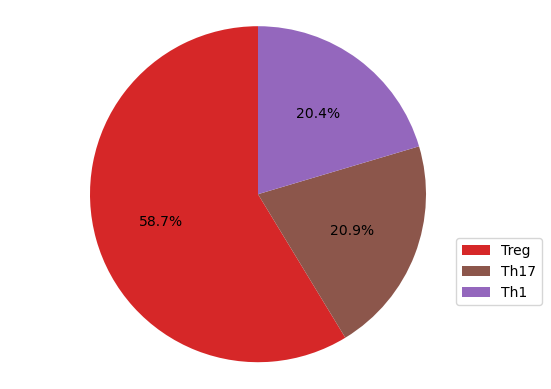

In [25]:
nfkb_mutant = stable_state.copy()
new_istates = change_inputs(nodes, to_istates(res_single[('NFKB', 'OFF')].get_states_probtraj(), nodes), dc_signal)
nfkb_mutant.network.set_istate(nodes, new_istates)
nfkb_mutant.network["NFKB"].set_rate(str(1),str(1))
res_mutant = nfkb_mutant.run()
res_mutant.plot_piechart()

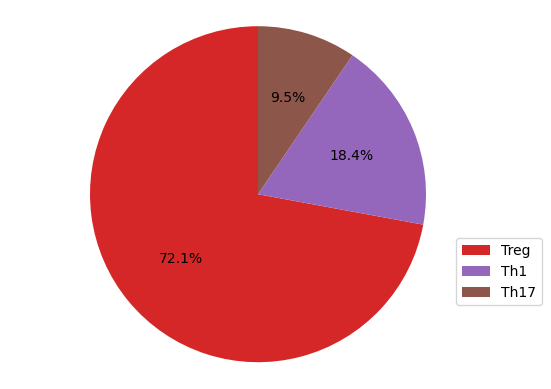

In [26]:
nfkb_mutant.network["NFKB"].set_rate(str(0.1),str(1))
res_mutant = nfkb_mutant.run()
res_mutant.plot_piechart()

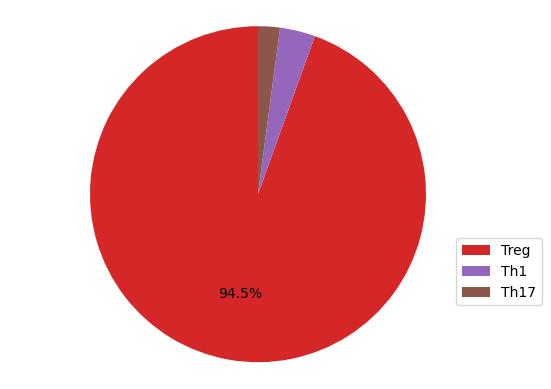

In [27]:
nfkb_mutant.network["NFKB"].set_rate(str(0.01),str(1))
res_mutant = nfkb_mutant.run()
res_mutant.plot_piechart()

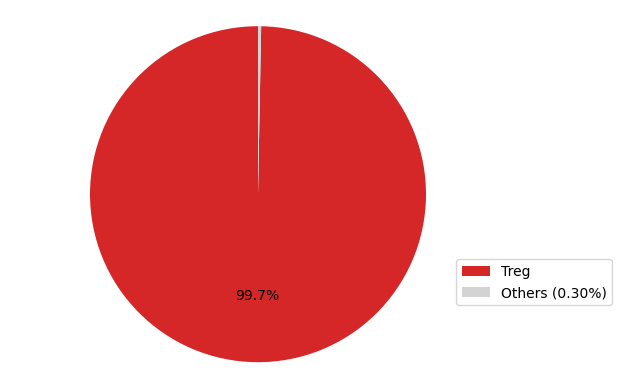

In [28]:
nfkb_mutant.network["NFKB"].set_rate(str(0.001),str(1))
res_mutant = nfkb_mutant.run()
res_mutant.plot_piechart()

By lowering the activation rate of NFkB (making it difficult to activate, so similar to a knock off ??), we increase the proportion of Tregs.

### FOXP3_2

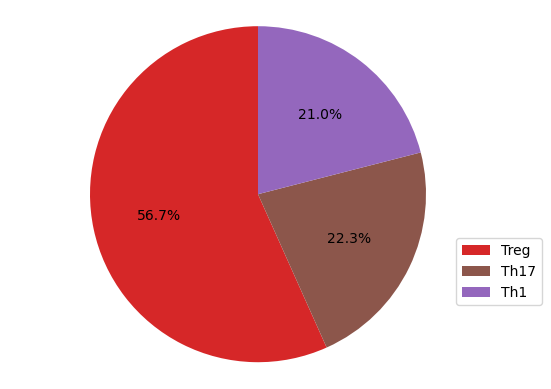

In [29]:
fox_mutant = stable_state.copy()
new_istates = change_inputs(nodes, to_istates(res_single[('FOXP3_2', 'OFF')].get_states_probtraj(), nodes), dc_signal)
fox_mutant.network.set_istate(nodes, new_istates)
fox_mutant.network["FOXP3_2"].set_rate(str(1),str(1))
res_mutant = fox_mutant.run()
res_mutant.plot_piechart()

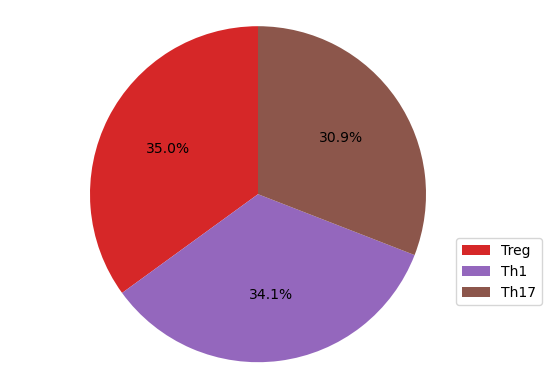

In [30]:
fox_mutant.network["FOXP3_2"].set_rate(str(0.2),str(1))
res_mutant = fox_mutant.run()
res_mutant.plot_piechart()

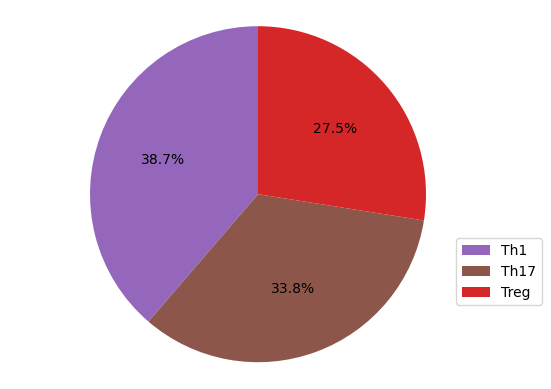

In [31]:
fox_mutant.network["FOXP3_2"].set_rate(str(0.1),str(1))
res_mutant = fox_mutant.run()
res_mutant.plot_piechart()

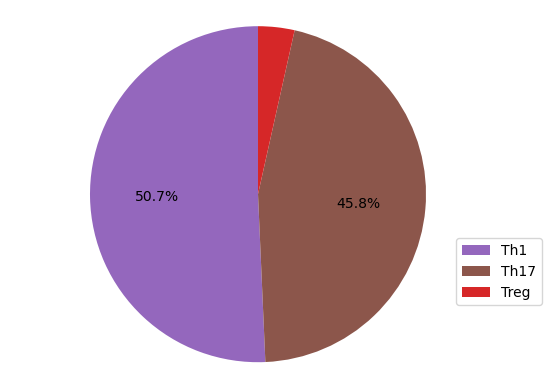

In [32]:
fox_mutant.network["FOXP3_2"].set_rate(str(0.01),str(1))
res_mutant = fox_mutant.run()
res_mutant.plot_piechart()

In the same idea, by decreasing the activation rate of FOXP3_2, we decrase the proportion of Tregs.